In [18]:
import urllib.request,sys,time
from bs4 import BeautifulSoup
import requests
import pandas as pd

pagesToGet= 10

upperframe=[]  
for page in range(1,pagesToGet+1):
    print('processing page :', page)
    url = 'https://www.politifact.com/factchecks/list/?page='+str(page)
    print(url)
    
    #an exception might be thrown, so the code should be in a try-except block
    try:
        #use the browser to get the url. This is suspicious command that might blow up.
        page=requests.get(url)                             # this might throw an exception if something goes wrong.
    
    except Exception as e:                                   # this describes what to do if an exception is thrown
        error_type, error_obj, error_info = sys.exc_info()      # get the exception information
        print ('ERROR FOR LINK:',url)                          #print the link that cause the problem
        print (error_type, 'Line:', error_info.tb_lineno)     #print error info and line that threw the exception
        continue                                              #ignore this page. Abandon this and go back.
    time.sleep(2)   
    soup=BeautifulSoup(page.text,'html.parser')
    frame=[]
    links=soup.find_all('li',attrs={'class':'o-listicle__item'})
    print(len(links))
    filename="/content/news/NEWS.csv"
    f=open(filename,"w", encoding = 'utf-8')
    headers="Statement,Link,Date,source,Label\n"
    f.write(headers)
    
    for j in links:
        Statement = j.find("div",attrs={'class':'m-statement__quote'}).text.strip()
        Link = "https://www.politifact.com"
        Link += j.find("div",attrs={'class':'m-statement__quote'}).find('a')['href'].strip()
        Date = j.find('div',attrs={'class':'m-statement__body'}).find('footer').text[-14:-1].strip()
        Source = j.find('div', attrs={'class':'m-statement__meta'}).find('a').text.strip()
        Label = j.find('div', attrs ={'class':'m-statement__content'}).find('img',attrs={'class':'c-image__original'}).get('alt').strip()
        frame.append((Statement,Link,Date,Source,Label))
        f.write(Statement.replace(",","^")+","+Link+","+Date.replace(",","^")+","+Source.replace(",","^")+","+Label.replace(",","^")+"\n")
    upperframe.extend(frame)
f.close()
data=pd.DataFrame(upperframe, columns=['Statement','Link','Date','source','Label'])
data.head()

processing page : 1
https://www.politifact.com/factchecks/list/?page=1
30
processing page : 2
https://www.politifact.com/factchecks/list/?page=2
30
processing page : 3
https://www.politifact.com/factchecks/list/?page=3
30
processing page : 4
https://www.politifact.com/factchecks/list/?page=4
30
processing page : 5
https://www.politifact.com/factchecks/list/?page=5
30
processing page : 6
https://www.politifact.com/factchecks/list/?page=6
30
processing page : 7
https://www.politifact.com/factchecks/list/?page=7
30
processing page : 8
https://www.politifact.com/factchecks/list/?page=8
30
processing page : 9
https://www.politifact.com/factchecks/list/?page=9
30
processing page : 10
https://www.politifact.com/factchecks/list/?page=10
30


,Statement,Link,Date,source,Label
0,"After Joe Biden became vice president, at the ...",https://www.politifact.com/factchecks/2022/dec...,"mber 20, 2022",Joe Biden,false
1,"Says he has been to “Afghanistan, Iraq and tho...",https://www.politifact.com/factchecks/2022/dec...,"mber 20, 2022",Joe Biden,false
2,“Literally five (homeless) people a day die on...,https://www.politifact.com/factchecks/2022/dec...,"mber 20, 2022",Karen Bass,mostly-true
3,Luana Stoltenberg “originally LOST her race fo...,https://www.politifact.com/factchecks/2022/dec...,"mber 20, 2022",Kari Lake,half-true
4,Tesla launched a cryptocurrency platform that ...,https://www.politifact.com/factchecks/2022/dec...,"mber 20, 2022",Bloggers,false


In [32]:
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [33]:


train_df = pd.read_csv(r'/content/news/NEWS.csv')
train_df.head()

,Statement,Link,Date,source,Label
0,“I don’t get involved in the hiring and firing...,https://www.politifact.com/factchecks/2022/nov...,ember 2^ 2022,Levar Stoney,false
1,“Marco Rubio le ha votado en contra a los Drea...,https://www.politifact.com/factchecks/2022/nov...,ember 1^ 2022,Florida Immigrant Coalition,half-true
2,“One in six local election officials have rece...,https://www.politifact.com/factchecks/2022/nov...,ember 1^ 2022,Amy Klobuchar,mostly-true
3,Police dispatch audio from Paul Pelosi’s attac...,https://www.politifact.com/factchecks/2022/nov...,ember 1^ 2022,Instagram posts,pants-fire
4,Kari Lake and Mark Finchem “have said that the...,https://www.politifact.com/factchecks/2022/nov...,ember 1^ 2022,Liz Cheney,mostly-true


In [34]:
train_df = train_df.drop("Link", axis = 1)
train_df = train_df.drop("Date", axis = 1)
train_df = train_df.drop("source", axis = 1)

In [35]:
train_df.shape

(30, 2)

In [40]:
train_df.head(15)

,Statement,Label
0,“I don’t get involved in the hiring and firing...,false
1,“Marco Rubio le ha votado en contra a los Drea...,half-true
2,“One in six local election officials have rece...,mostly-true
3,Police dispatch audio from Paul Pelosi’s attac...,pants-fire
4,Kari Lake and Mark Finchem “have said that the...,mostly-true
5,Security cameras at Nancy Pelosi’s San Francis...,pants-fire
6,“If outer space was a vacuum^ astronauts would...,pants-fire
7,“We finally achieved that energy independence…...,barely-true
8,Don Bolduc wants to cut trillions from Medicar...,mostly-true
9,Document shows Rebekah Jones “demonstrated” a ...,false


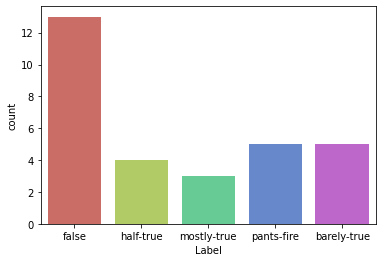

In [41]:
def create_distribution(dataFile):
    return sb.countplot(x='Label', data=dataFile, palette='hls')

# by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
create_distribution(train_df)

In [42]:
def data_qualityCheck():
    print("Checking data qualitites...")
    train_df.isnull().sum()
    train_df.info()  
    print("check finished.")
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  30 non-null     object
 1   Label      30 non-null     object
dtypes: object(2)
memory usage: 608.0+ bytes
check finished.


In [43]:
train_df = train_df.dropna()

In [44]:
data_qualityCheck()

Checking data qualitites...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  30 non-null     object
 1   Label      30 non-null     object
dtypes: object(2)
memory usage: 720.0+ bytes
check finished.


In [45]:
train_df.shape

(30, 2)

In [46]:
train_df.head(10)

,Statement,Label
0,“I don’t get involved in the hiring and firing...,false
1,“Marco Rubio le ha votado en contra a los Drea...,half-true
2,“One in six local election officials have rece...,mostly-true
3,Police dispatch audio from Paul Pelosi’s attac...,pants-fire
4,Kari Lake and Mark Finchem “have said that the...,mostly-true
5,Security cameras at Nancy Pelosi’s San Francis...,pants-fire
6,“If outer space was a vacuum^ astronauts would...,pants-fire
7,“We finally achieved that energy independence…...,barely-true
8,Don Bolduc wants to cut trillions from Medicar...,mostly-true
9,Document shows Rebekah Jones “demonstrated” a ...,false


In [47]:
train_df.reset_index(drop= True,inplace=True)

In [48]:
train_df.head(10)

,Statement,Label
0,“I don’t get involved in the hiring and firing...,false
1,“Marco Rubio le ha votado en contra a los Drea...,half-true
2,“One in six local election officials have rece...,mostly-true
3,Police dispatch audio from Paul Pelosi’s attac...,pants-fire
4,Kari Lake and Mark Finchem “have said that the...,mostly-true
5,Security cameras at Nancy Pelosi’s San Francis...,pants-fire
6,“If outer space was a vacuum^ astronauts would...,pants-fire
7,“We finally achieved that energy independence…...,barely-true
8,Don Bolduc wants to cut trillions from Medicar...,mostly-true
9,Document shows Rebekah Jones “demonstrated” a ...,false


In [50]:
label_train = train_df.Label

In [51]:
label_train.head(10)

0          false
1      half-true
2    mostly-true
3     pants-fire
4    mostly-true
5     pants-fire
6     pants-fire
7    barely-true
8    mostly-true
9          false
Name: Label, dtype: object

In [53]:
train_df = train_df.drop("Label", axis = 1)

In [54]:
train_df.head(10)

,Statement
0,“I don’t get involved in the hiring and firing...
1,“Marco Rubio le ha votado en contra a los Drea...
2,“One in six local election officials have rece...
3,Police dispatch audio from Paul Pelosi’s attac...
4,Kari Lake and Mark Finchem “have said that the...
5,Security cameras at Nancy Pelosi’s San Francis...
6,“If outer space was a vacuum^ astronauts would...
7,“We finally achieved that energy independence…...
8,Don Bolduc wants to cut trillions from Medicar...
9,Document shows Rebekah Jones “demonstrated” a ...


In [56]:
train_df['Statement'][20]

'Deidre DeJear refused to stand for police.'

In [57]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [58]:
stpwrds

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [67]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [68]:
for x in range(len(train_df)):
  corpus = []
  review = train_df['Statement'][x]
  review = re.sub(r'[^a-zA-Z\s]', '', review)
  review = review.lower()
  review = nltk.word_tokenize(review)
  for y in review :
    if y not in stpwrds :
      corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    train_df['Statement'][x] = review   

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df['Statement'], label_train, test_size=0.3, random_state=1)

In [70]:
X_train

22           rep tim ryan wanted decriminalize fentanyl
23               pennsylvania drop box preloaded ballot
4     kari lake mark finchem said honor result elect...
2     one six local election official received threa...
25    mcdonalds us potato sprayed highly toxic pesti...
6     outer space vacuum astronaut would train vacuu...
18       cheri beasley back tax hike even family making
13      heckler chanted f joe biden barack obama speech
7     finally achieved energy independence trump adm...
27             kid resistant covid opposed older people
1        marco rubio le ha votado en contra los dreamer
16                  video show military robot ready war
0                                                      
15    video show marjorie taylor greene planted pipe...
29    democratic city take day count vote rest count...
28               crime governor desantis crime governor
9     document show rebekah jones demonstrated viola...
8     bolduc want cut trillion medicare end soci

In [71]:
tfidf_v = TfidfVectorizer()
tfidf_X_train = tfidf_v.fit_transform(X_train)
tfidf_X_test = tfidf_v.transform(X_test)

In [72]:
tfidf_X_train.shape

(21, 167)

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [74]:
classifier = PassiveAggressiveClassifier()
classifier.fit(tfidf_X_train,Y_train)

PassiveAggressiveClassifier()

Accuracy: 33.33%
Confusion matrix, without normalization


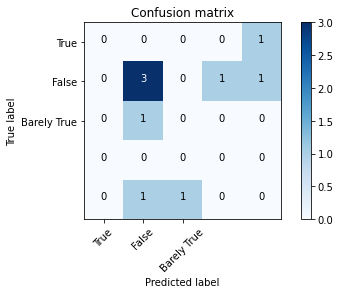

In [77]:
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {round(score*100,2)}%')
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, classes=['True', 'False','Barely True'])


In [76]:
pickle.dump(classifier,open('./model.pkl', 'wb'))

In [78]:
loaded_model = pickle.load(open('./model.pkl', 'rb'))


In [79]:
def fake_news_det(news):
    review = news
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))     
    input_data = [' '.join(corpus)]
    vectorized_input_data = tfidf_v.transform(input_data)
    prediction = loaded_model.predict(vectorized_input_data)
    if prediction[0] == 0:
        print("Prediction of the News :  Looking Fake⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Real News📰 ")